Data shape: (13436, 5)
Number of classes: 20

Target distribution:
 LC_Kategori
Dil ve Edebiyat             3274
Tıp                         2703
Hukuk                       1016
Siyaset Bilimi              1001
Felsefe, Psikoloji, Din      965
Bilim                        957
Güzel Sanatlar               952
Eğitim                       913
Sosyal Bilimler              904
Müzik                         79
Askerlik                      74
Kaynakçalar                   72
Tarih                         71
Genel Yapıtlar                69
Denizcilik                    69
Tarihe Yardımcı Bilimler      67
Bilinmeyen                    66
Coğrafya                      64
Tarım                         63
Teknoloji                     57
Name: count, dtype: int64

[Baseline] Training Logistic Regression...

===== Baseline - Logistic Regression =====
Accuracy: 0.7306547619047619
F1 macro: 0.345194857938531

Classification report:
                           precision    recall  f1-score   suppor

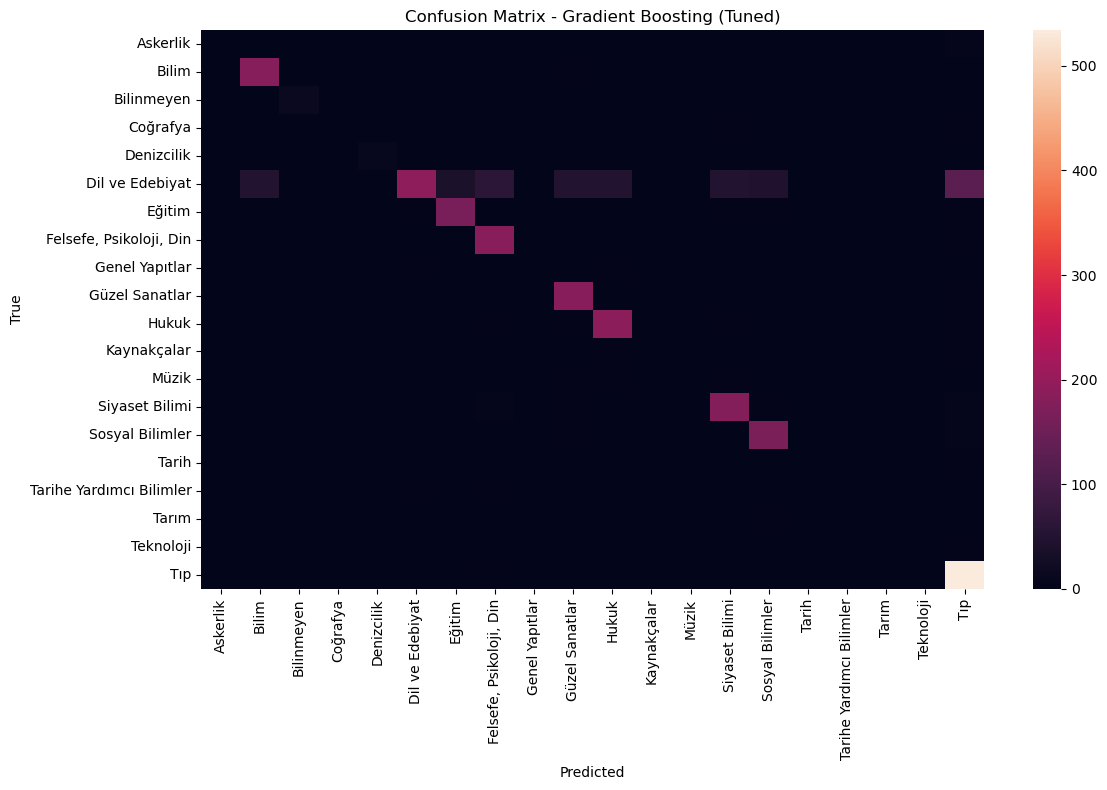

[GB] Saved: gradient_boosting_tuned_final.joblib

[ExtraTrees] Tuning started...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[ExtraTrees] Best params: {'model__n_estimators': 600, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 20, 'model__bootstrap': False}

===== Advanced 2 - Extra Trees (Tuned) =====
Accuracy: 0.7325148809523809
F1 macro: 0.38052303317358616

Classification report:
                           precision    recall  f1-score   support

                Askerlik       0.00      0.00      0.00        15
                   Bilim       0.73      0.94      0.82       192
              Bilinmeyen       1.00      0.15      0.27        13
                Coğrafya       0.00      0.00      0.00        13
              Denizcilik       1.00      0.07      0.13        14
         Dil ve Edebiyat       0.87      0.29      0.43       655
                  Eğitim       0.76      0.89      0.82       183
 Fe

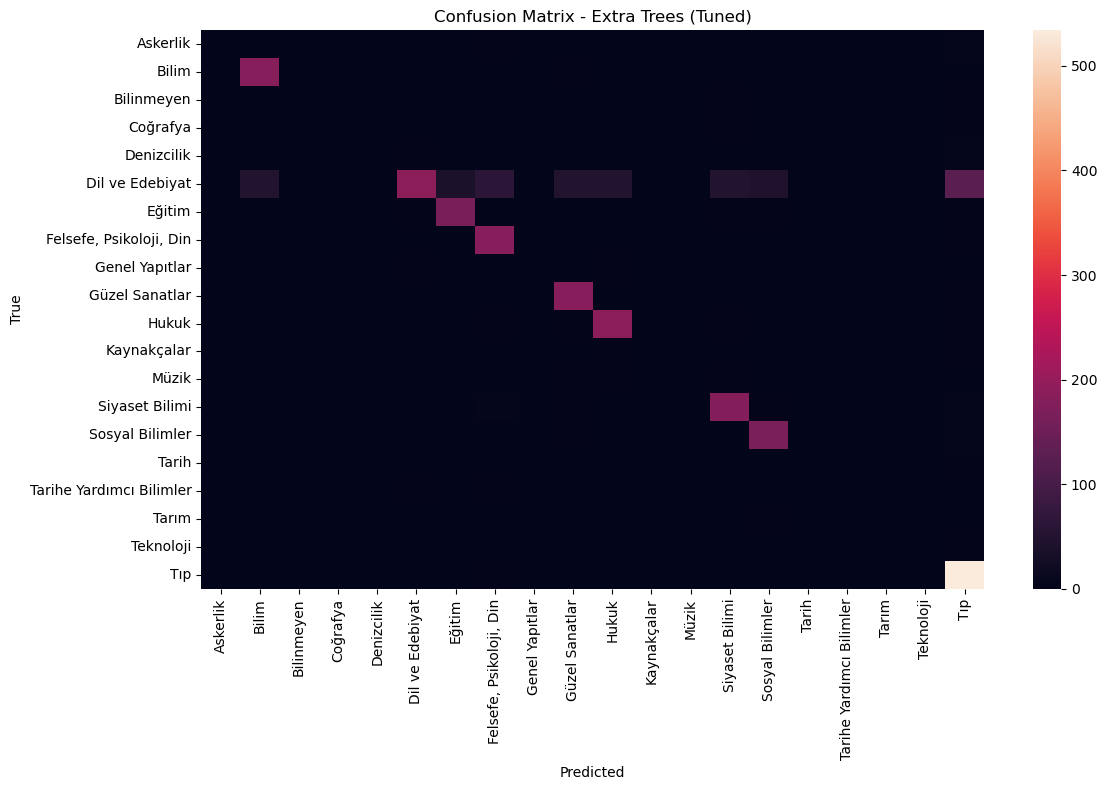

[ExtraTrees] Saved: extra_trees_tuned_final.joblib

===== Final Comparison (sorted by F1_macro) =====


,Model,Accuracy,F1_macro
1,Advanced - GradientBoosting (Tuned),0.743676,0.510756
2,Advanced - ExtraTrees (Tuned),0.732515,0.380523
0,Baseline - LogisticRegression,0.730655,0.345195



Done. Saved outputs:
 - cm_gradient_boosting_tuned.png
 - cm_extra_trees_tuned.png
 - baseline_logreg_final.joblib
 - gradient_boosting_tuned_final.joblib
 - extra_trees_tuned_final.joblib


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# ===========================
# 1) Load data
# ===========================
file_path = "Odunc_Guncel_Kategorili_Liste.xlsx"
df = pd.read_excel(file_path)

target_col = "LC_Kategori"

# drop identifier column if exists
if "ÖğrenciKimlik-no" in df.columns:
    df = df.drop(columns=["ÖğrenciKimlik-no"])

X = df.drop(columns=[target_col])
y = df[target_col]

print("Data shape:", df.shape)
print("Number of classes:", y.nunique())
print("\nTarget distribution:\n", y.value_counts())


# ===========================
# 2) Split
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

def evaluate(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
    print(f"\n===== {model_name} =====")
    print("Accuracy:", acc)
    print("F1 macro:", f1m)
    print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))
    return acc, f1m

def plot_cm(title, y_true, y_pred, labels, save_path):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=False, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


labels_sorted = sorted(y.unique())
results = []


# ===========================
# 3) Baseline: Logistic Regression (no tuning)
# ===========================
baseline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, multi_class="multinomial"))
])

print("\n[Baseline] Training Logistic Regression...")
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

base_acc, base_f1m = evaluate("Baseline - Logistic Regression", y_test, y_pred_base)
results.append({"Model": "Baseline - LogisticRegression", "Accuracy": base_acc, "F1_macro": base_f1m})

joblib.dump(baseline, "baseline_logreg_final.joblib")
print("[Baseline] Saved: baseline_logreg_final.joblib")


# ===========================
# 4) Advanced Model 1: Gradient Boosting (tuned)
# ===========================
gb = GradientBoostingClassifier(random_state=42)

gb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gb)
])

gb_params = {
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__max_depth": [2, 3, 5],
    "model__subsample": [0.8, 1.0]
}

gb_search = RandomizedSearchCV(
    gb_pipe,
    param_distributions=gb_params,
    n_iter=15,
    scoring="f1_macro",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n[GB] Tuning started...")
gb_search.fit(X_train, y_train)

best_gb = gb_search.best_estimator_
print("[GB] Best params:", gb_search.best_params_)

y_pred_gb = best_gb.predict(X_test)
gb_acc, gb_f1m = evaluate("Advanced 1 - Gradient Boosting (Tuned)", y_test, y_pred_gb)
results.append({"Model": "Advanced - GradientBoosting (Tuned)", "Accuracy": gb_acc, "F1_macro": gb_f1m})

plot_cm("Confusion Matrix - Gradient Boosting (Tuned)", y_test, y_pred_gb, labels_sorted, "cm_gradient_boosting_tuned.png")

joblib.dump(best_gb, "gradient_boosting_tuned_final.joblib")
print("[GB] Saved: gradient_boosting_tuned_final.joblib")


# ===========================
# 5) Advanced Model 2: Extra Trees (tuned)
# ===========================
et = ExtraTreesClassifier(random_state=42, n_jobs=-1)

et_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", et)
])

et_params = {
    "model__n_estimators": [300, 600, 900],
    "model__max_depth": [None, 10, 20, 40],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None],
    "model__bootstrap": [False, True]
}

et_search = RandomizedSearchCV(
    et_pipe,
    param_distributions=et_params,
    n_iter=20,
    scoring="f1_macro",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n[ExtraTrees] Tuning started...")
et_search.fit(X_train, y_train)

best_et = et_search.best_estimator_
print("[ExtraTrees] Best params:", et_search.best_params_)

y_pred_et = best_et.predict(X_test)
et_acc, et_f1m = evaluate("Advanced 2 - Extra Trees (Tuned)", y_test, y_pred_et)
results.append({"Model": "Advanced - ExtraTrees (Tuned)", "Accuracy": et_acc, "F1_macro": et_f1m})

plot_cm("Confusion Matrix - Extra Trees (Tuned)", y_test, y_pred_et, labels_sorted, "cm_extra_trees_tuned.png")

joblib.dump(best_et, "extra_trees_tuned_final.joblib")
print("[ExtraTrees] Saved: extra_trees_tuned_final.joblib")


# ===========================
# 6) Final comparison table
# ===========================
results_df = pd.DataFrame(results).sort_values(by="F1_macro", ascending=False)

print("\n===== Final Comparison (sorted by F1_macro) =====")
display(results_df)

print("\nDone. Saved outputs:")
print(" - cm_gradient_boosting_tuned.png")
print(" - cm_extra_trees_tuned.png")
print(" - baseline_logreg_final.joblib")
print(" - gradient_boosting_tuned_final.joblib")
print(" - extra_trees_tuned_final.joblib")
